# Dipole study for Kretschmann configuration

Katya Zossimova | June 2021

### Import 

In [27]:
from __future__ import division, print_function, absolute_import

from tmm import (coh_tmm, unpolarized_RT, ellips,
                       position_resolved, find_in_structure_with_inf,
                       coh_tmm_reverse, list_snell)

import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
try:
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color
    colors_were_imported = True
except ImportError:
    # without colorpy, you can't run sample5(), but everything else is fine.
    colors_were_imported = False


# "5 * degree" is 5 degrees expressed in radians
# "1.2 / degree" is 1.2 radians expressed in degrees
degree = np.pi/180
# vacuum impedance
eta0 = 377
# water impedance
eta = 377 / 1.33

### Functions

In [70]:
def find_max_field_enhancement(n_list, d_list, lam_vac):
    
    # calculate the electric field enhancent at the surface of the final layer
    layer = len(n_list)-1
    d_in_layer = 0 
    
    theta_list = np.linspace(0*degree, 90*degree, num=901)
    # calculate angle of incidence for maximum field enhancement
    # only consider p-polarized light for excitation
    field_enhancement=[]        
    for theta in theta_list:
        coh_tmm_data = coh_tmm('p', n_list, d_list, theta, lam_vac)
        data = position_resolved(layer, d_in_layer, coh_tmm_data)
        Ep = array([data['Ex'], data['Ey'], data['Ez']])
        magnitude = np.linalg.norm(Ep)    
        field_enhancement.append(magnitude)
      
    theta_opt = theta_list[find_peaks(field_enhancement)[0]]
    enhancement = max(field_enhancement)
    
    return float(theta_opt), enhancement

In [71]:
def dipole_moment(alpha, n_list, d_list, theta_opt, lam_vac):
    
    layer = len(n_list)-1
    d_in_layer = 0 
    
    coh_tmm_data = coh_tmm('p', n_list, d_list, theta_opt, lam_vac)
    data = position_resolved(layer,d_in_layer,coh_tmm_data)

    Ex = data['Ex']
    Ey = data['Ey']
    Ez = data['Ez']

    dipole = alpha * np.array([Ex, Ey, Ez])
    
    return dipole

In [72]:
def radiation_pattern(dipole, n_list, d_list, lam_vac):
    
    # reverse the orders of the layers to calculate the inverse incidence
    # with Lorentz reciprocity theory
    n_list.reverse()
    d_list.reverse() 
    # insert a fictitious water layer to access the exact position of the dipole
    n_list.insert(1, 1.33)
    d_list.insert(1, 100)

    theta_list = np.linspace(0*degree, 90*degree, num=401)
    poynting = []

    for theta in theta_list:
        coh_tmm_pdata = coh_tmm('p', n_list, d_list, theta, lam_vac)
        pdata = position_resolved(1, d_list[1], coh_tmm_pdata)
        Ep = np.array([pdata['Ex'], pdata['Ey'], pdata['Ez']])
        
        coh_tmm_sdata = coh_tmm('s', n_list, d_list, theta, lam_vac)
        sdata = position_resolved(1, d_list[1], coh_tmm_sdata)
        Es = np.array([sdata['Ex'], sdata['Ey'], sdata['Ez']])
        
        intensity =  abs(Es.dot(dipole)) ** 2 + abs(Ep.dot(dipole)) ** 2
        
        poynting.append(intensity / (2*eta))
        
    # Return to original arrays 
    n_list.pop(1)
    d_list.pop(1)
    n_list.reverse()
    d_list.reverse()
    
    return theta_list, poynting

In [77]:
def theta_integral(theta, dipole, n_list, d_list, lam_vac):

    n_list.reverse()
    d_list.reverse() 

    n_list.insert(1, 1.33)
    d_list.insert(1, 100)

    coh_tmm_pdata = coh_tmm('p', n_list, d_list, theta, lam_vac)
    pdata = position_resolved(1, d_list[1], coh_tmm_pdata)
    Ep = np.array([pdata['Ex'], pdata['Ey'], pdata['Ez']])
    
    coh_tmm_sdata = coh_tmm('s', n_list, d_list, theta, lam_vac)
    sdata = position_resolved(1, d_list[1], coh_tmm_sdata)
    Es = np.array([sdata['Ex'], sdata['Ey'], sdata['Ez']])

    intensity = abs(Es.dot(dipole)) ** 2 + abs(Ep.dot(dipole)) ** 2
    
    mag = intensity/(2*eta)
    
    # Return to original arrays 
    n_list.pop(1)
    d_list.pop(1)
    n_list.reverse()
    d_list.reverse()
    
    return 2 * np.pi * mag * np.cos(theta)

### Kretschmann

1.	Consider a spherical dipole with real-valued scalar polarizability on the surface, study how it scatter light. The signal will be proportional to $\alpha^2$. Then, we can add imaginary part to the polarizability and study its effect. In this way, we can get a map for independent real and imaginary parts of alpha. To complete this study, we can add to that map real spherical molecules and nanoparticles.

#### Real Polarizability

[57.375]
[57.375]
[57.375]
[57.375]
[57.375]
[57.375]
[57.375]
[57.375]
[57.375]
[57.375]


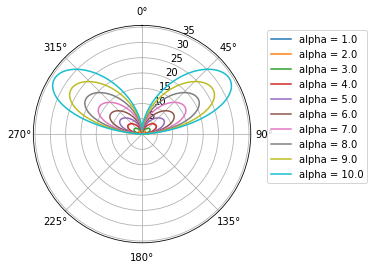

In [76]:
alpha_list = np.linspace(1., 10., 10)
n_list = [1.85, 3.1243+3.4422j, 0.1194+4.7347j, 1.52, 1.33]
d_list = [np.inf, 2, 48, 22, np.inf]
theta_opt = 49.83 * degree
lam_vac = 780

ax = plt.subplot(111, projection='polar')

for alpha in alpha_list:
    
    dipole = dipole_moment(alpha, n_list, d_list, theta_opt, lam_vac)
    theta_list, poynting = radiation_pattern(dipole, n_list, d_list, lam_vac)
    
    print(theta_list[find_peaks(poynting)[0]]/ degree)
    
    plotted_line = ax.plot(theta_list, poynting)
    ax.plot(-theta_list, poynting, color=plotted_line[0].get_color(), label=f"alpha = {alpha}")
    
#ax.set_rmax(1.5)
#ax.set_rticks([])
ax.grid(True)
ax.set_rlabel_position(22)
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

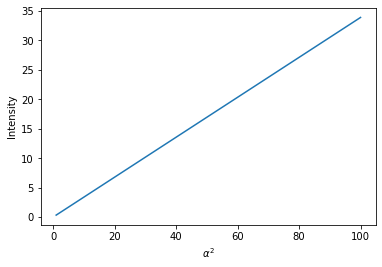

In [78]:
alpha_list = np.linspace(1., 10., 10)
n_list = [1.85, 3.1243+3.4422j, 0.1194+4.7347j, 1.52, 1.33]
d_list = [np.inf, 2, 48, 22, np.inf]
theta_opt = 49.83 * degree
lam_vac = 780

plt.figure()

intensity = []
for alpha in alpha_list:

    dipole = dipole_moment(alpha, n_list, d_list, theta_opt, lam_vac)
    theta_list, poynting = radiation_pattern(dipole, n_list, d_list, lam_vac)
    intensity.append(max(poynting))

plt.plot(alpha_list ** 2, intensity)
plt.xlabel('$α^2$')
plt.ylabel('Intensity')

plt.show()

#### Imaginary Polarizability

[57.375]
[57.375]
[57.375]
[57.375]
[57.375]
[57.375]
[57.375]
[57.375]
[57.375]
[57.375]


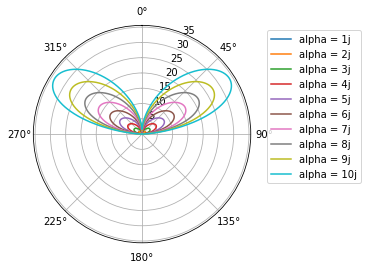

In [79]:
alpha_list = np.linspace(1j, 10j, 10)
n_list = [1.85, 3.1243+3.4422j, 0.1194+4.7347j, 1.52, 1.33]
d_list = [np.inf, 2, 48, 22, np.inf]
theta_opt = 49.83 * degree
lam_vac = 780

ax = plt.subplot(111, projection='polar')

for alpha in alpha_list:
    
    dipole = dipole_moment(alpha, n_list, d_list, theta_opt, lam_vac)
    theta_list, poynting = radiation_pattern(dipole, n_list, d_list, lam_vac)
    
    print(theta_list[find_peaks(poynting)[0]]/ degree)
    
    plotted_line = ax.plot(theta_list, poynting)
    ax.plot(-theta_list, poynting, color=plotted_line[0].get_color(), label=f"alpha = {alpha}")
    
#ax.set_rmax(1.5)
#ax.set_rticks([])
ax.grid(True)
ax.set_rlabel_position(22)
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

2.	We can test the dipole model for spherical nanoparticles and compare with Comsol simulation. A short study, more suitable for conference publication.

3.	Now, we use the spacer from my previous publication. It is unoptimized for our case; it depends on the wavelength used. We can do optimization study and study quenching as well. But we have to limit the study to particular molecule.

4.	Study asymmetric molecules with polarizability tensor, explore how their position and orientation affect their scattering.